In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/janata-hack-nlp/roberta_tk1.93.84.npy
/kaggle/input/janata-hack-nlp/game_overview.csv
/kaggle/input/janata-hack-nlp/test.csv
/kaggle/input/janata-hack-nlp/roberta_tk1.93.94.npy
/kaggle/input/janata-hack-nlp/sample_submission_wgBqZCk.csv
/kaggle/input/janata-hack-nlp/train.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [3]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.60
transformers version : 2.7.0


In [4]:
seed = 78563
use_fp16 = False
bs = 2

In [5]:
basepath = "/kaggle/input/janata-hack-nlp/"
working = "/kaggle/working/"
working_cls = "/kaggle/working/cls/"

df = pd.read_csv(f"{basepath}/train.csv")
overview_df = pd.read_csv(f"{basepath}/game_overview.csv")
test_df = pd.read_csv(f"{basepath}/test.csv")
subs_df = pd.read_csv(f"{basepath}/sample_submission_wgBqZCk.csv")

In [6]:
df

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1
...,...,...,...,...,...
17489,25535,EverQuest II,2012.0,Arguably the single greatest mmorp that exists...,1
17490,25536,EverQuest II,2017.0,"An older game, to be sure, but has its own cha...",1
17491,25537,EverQuest II,2011.0,When I frist started playing Everquest 2 it wa...,1
17492,25538,EverQuest II,NaN,cool game. THe only thing that REALLY PISSES M...,1


In [7]:
overview_df

,title,developer,publisher,tags,overview
0,Spooky's Jump Scare Mansion,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...
1,Sakura Clicker,Winged Cloud,Winged Cloud,"['Nudity', 'Anime', 'Free to Play', 'Mature', ...",The latest entry in the Sakura series is more ...
2,WARMODE,WARTEAM,WARTEAM,"['Early Access', 'Free to Play', 'FPS', 'Multi...",Free to play shooter about the confrontation o...
3,Fractured Space,Edge Case Games Ltd.,Edge Case Games Ltd.,"['Space', 'Multiplayer', 'Free to Play', 'PvP'...",Take the helm of a gigantic capital ship and g...
4,Counter-Strike: Global Offensive,"Valve, Hidden Path Entertainment",Valve,"['FPS', 'Multiplayer', 'Shooter', 'Action', 'T...",Counter-Strike: Global Offensive (CS: GO) expa...
...,...,...,...,...,...
59,Bloons TD Battles,Ninja Kiwi,Ninja Kiwi,"['Free to Play', 'Tower Defense', 'Multiplayer...",Play the top-rated tower defense franchise in ...
60,Cuisine Royale,Darkflow Software,Gaijin Distribution KFT,"['Early Access', 'Free to Play', 'Battle Royal...",Cuisine Royale is an all-kitchen-warfare Battl...
61,GUNS UP!,"Valkyrie Entertainment, LLC","PlayStation Mobile, Inc.","['Free to Play', 'Strategy', 'Multiplayer', 'A...","In a mashup of RTS & Tower Defense, GUNS UP! i..."
62,School of Dragons,"JumpStart Games, Inc.","JumpStart Games, Inc.","['Free to Play', 'Dragons', 'Adventure', 'Mult...",**Changewing Dragon now Available**Fly Fast. T...


In [8]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  # needed
        torch.backends.cudnn.benchmark = False
        
seed_all(seed)

In [9]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [10]:
model_type = 'roberta'
pretrained_model_name = 'roberta-large'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

In [11]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [12]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

In [13]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [14]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer=transformer_tokenizer, model_type=model_type)
fastai_tokenizer = Tokenizer(tok_func=transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [15]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [16]:
transformer_vocab =  TransformersVocab(tokenizer=transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [17]:
pad_first = bool(model_type in [model_type])
pad_idx = transformer_tokenizer.pad_token_id

tokens = transformer_tokenizer.tokenize('Victory loves preparation')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['Vict', 'ory', 'Ġloves', 'Ġpreparation']
[32094, 4405, 6138, 7094]


['Vict', 'ory', 'Ġloves', 'Ġpreparation']

In [18]:
test_tl = TextList.from_csv(basepath, 'test.csv', cols='user_review')
data_clas = (TextList.from_csv(basepath, 'train.csv', cols='user_review', processor=transformer_processor)
                .split_by_rand_pct(0.01, seed=seed)
                .label_from_df(cols="user_suggestion")
                .add_test(test_tl)
                .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [19]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
data_clas.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


text,target
<s> ĠThis Ġgame Ġlooked Ġinteresting Ġso ĠI Ġdecided Ġto Ġgive Ġit Ġa Ġtry . Ġ ĠI Ġplay Ġsingle Ġplayer Ġand Ġafter Ġa Ġcouple Ġof Ġhours Ġthis Ġgame Ġbecame Ġtedious Ġand Ġboring . Ġ ĠI Ġhave Ġa Ġlogical Ġmind Ġand Ġone Ġof Ġmy Ġfirst Ġissues Ġwith Ġthe Ġgame Ġis Ġthat Ġthe Ġcrafting Ġrecipes Ġare Ġdumb . Ġ ĠSome Ġof Ġthe Ġrecipes Ġhave Ġredundant Ġmaterials Ġlike Ġneeding Ġbedrock Ġand Ġstone Ġsl abs,0
"<s> ĠI Ġwanted Ġto Ġlike Ġthis Ġgame , Ġsince ĠUS Ġdevelopers / pub lisher s Ġhave Ġabandoned Ġmainline ĠMM ORPG s . PRO ĠSummary :- ĠGood Ġ3 D Ġgraphics - ĠSome Ġnovelty Ġin Ġcombat Ġmechanics - ĠEasy Ġto Ġfollow Ġquest Ġsequences - ĠNo Ġgender - locked Ġclasses - ĠPv E Ġand ĠPvP Ġplay - ĠTerritory Ġownership Ġfor Ġguild s CON s ĠSummary - ĠFPS Ġst utters Ġheavily - ĠMessages Ġcan",0


In [20]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = data_clas.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([2, 512])
tensor([[    0,   152,    16,  ...,   182, 10314,     2],
        [    0,    38,    74,  ...,    53,   224,     2]])


In [21]:
class CustomClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.LayerNorm(512),
            nn.Dropout(0.1),
            nn.Linear(512, 2),
        )
        
    def forward(self, features):
        x = features[:, 0, :] 
        x = self.classifier(x)
        return(x)
    
    
class CustomRobertaClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        # print(self.transformer.classifier)
        # self.transformer.classifier = CustomClassifier()
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids, attention_mask=attention_mask)[0]
        return logits

In [22]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config.use_bfloat16 = use_fp16
print(config)


RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 514,
  "min_length": 0,
  "model_type": "roberta",
  "no_repeat_ngram_size": 0,
  "num_attention_heads": 16,
  "num_beams": 1,
  "num_hidden_layers": 24,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 1,
  "prefix": null,
  "prun

In [23]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config=config)
custom_transformer_model = CustomTransformerModel(transformer_model=transformer_model)

In [24]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(data_clas, 
                  custom_transformer_model, 
                  opt_func=CustomAdamW, 
                  metrics=[accuracy, error_rate])
learner.model_dir = working

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [25]:
# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.encoder.layer[12],
              learner.model.transformer.roberta.encoder.layer[13],
              learner.model.transformer.roberta.encoder.layer[14],
              learner.model.transformer.roberta.encoder.layer[15],
              learner.model.transformer.roberta.encoder.layer[16],
              learner.model.transformer.roberta.encoder.layer[17],
              learner.model.transformer.roberta.encoder.layer[18],
              learner.model.transformer.roberta.encoder.layer[19],
              learner.model.transformer.roberta.encoder.layer[20],
              learner.model.transformer.roberta.encoder.layer[21],
              learner.model.transformer.roberta.encoder.layer[22],
              learner.model.transformer.roberta.encoder.layer[23],
              learner.model.transformer.roberta.pooler]

learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in', num_groups, 'groups')

Learner split in 26 groups


In [26]:
# learner.freeze_to(-1)
# learner.lr_find()
# learner.recorder.plot()

In [27]:
learner.freeze_to(-1)
learner.fit_one_cycle(1, max_lr=1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.327329,0.281944,0.885057,0.114943,08:30


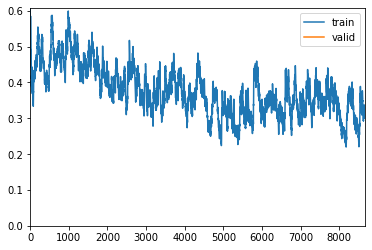

In [28]:
learner.freeze_to(-2)
lr = 1e-5
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.176461,0.248438,0.902299,0.097701,09:19


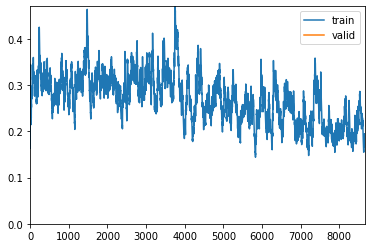

In [29]:
learner.freeze_to(-3)
lr = 1e-5
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [30]:
learner.unfreeze()
lr = 5e-6
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.212994,0.194489,0.919540,0.080460,30:42
1,0.103287,0.206650,0.919540,0.080460,30:48


In [31]:
# !rm /kaggle/working/tmp.pth

try:
    os.remove('/kaggle/working/tmp.pth')
except:
    pass

In [32]:
learner.save('final')

In [33]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data_clas.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

preds_test = get_preds_as_nparray(DatasetType.Test)

In [34]:
preds_test.tofile("roberta_tk1.npy")
preds_test

array([[0.177724, 0.822276],
       [0.996877, 0.003123],
       [0.995722, 0.004278],
       [0.939459, 0.060541],
       ...,
       [0.987404, 0.012596],
       [0.826471, 0.173529],
       [0.004783, 0.995217],
       [0.008093, 0.991907]], dtype=float32)

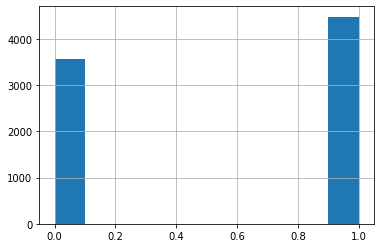

In [35]:
subs_df['user_suggestion'] = preds_test.argmax(axis=1)
subs_df.to_csv("submissions.csv", index=False)
subs_df['user_suggestion'].hist()